In [5]:
import sys
import os
import warnings

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

C:\Users\Ananya\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Ananya\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

## Setup

In [7]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [8]:
# Read in data
forex = pd.read_csv('./GBPUSD.csv')
model_scores = pd.read_csv("./Model scores.csv", index_col=0)

# Convert series into datetime type
forex.index = pd.to_datetime(forex['Date'])

# Save target series
series = forex['Close']
series

Date
2004-01-01    1.785204
2004-01-02    1.793690
2004-01-05    1.807207
2004-01-06    1.821295
2004-01-07    1.817785
                ...   
2022-08-24    1.183278
2022-08-25    1.179176
2022-08-26    1.182401
2022-08-29    1.169454
2022-08-30    1.172251
Name: Close, Length: 4852, dtype: float64

In [9]:
df = pd.DataFrame()
# calculate MA5 and MA20 to take as our features
df['MA5'] = series.rolling(window=5).mean()
df['MA20'] = series.rolling(window=2).mean()
df['next_prediction'] = series.shift(-1)
df.dropna(inplace=True)

X = df[['MA5','MA20']]
y = df['next_prediction']

In [12]:
#Size of exchange rates
total_size = df.shape[0]
print(total_size)

#Use 80% of data as training, rest 20% to Test the model
train_split_index = int(total_size * 0.8)
test_split_index = int(total_size * 0.2)
x_train = X.iloc[0:train_split_index]
y_train = y.iloc[0:train_split_index]

x_test = X.iloc[-test_split_index:total_size]
y_test = y.iloc[-test_split_index:total_size]

4847


In [13]:
x_train

,MA5,MA20
Date,,
2004-01-07,1.805036,1.819540
2004-01-08,1.814773,1.825836
2004-01-09,1.825652,1.840987
2004-01-12,1.833330,1.846842
2004-01-13,1.838832,1.847201
...,...,...
2018-12-03,1.278362,1.276897
2018-12-04,1.276633,1.273968
2018-12-05,1.276170,1.272321


# Linear Model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(x_train, y_train)

# print linear equation generated
print("GBPUSD Price (y) = %.2f * 5 day Moving Average (x1) + %.2f * 20 day Moving Average (x2) + %.2f (constant)" 
      % (model.coef_[0], model.coef_[1], model.intercept_))

y_predict = model.predict(x_test)

GBPUSD Price (y) = -0.23 * 5 day Moving Average (x1) + 1.22 * 20 day Moving Average (x2) + 0.00 (constant)


In [19]:
print("regression coefficient",model.coef_)
print("regression intercept",model.intercept_)

regression coefficient [-0.22514069  1.22410419]
regression intercept 0.0015202358028350016


#### Linear Model Result

In [20]:
df_actual_predicted = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': y_predict})
df_actual_predicted.head(10)

,Actual_Price,Predicted_Price
Date,,
2018-12-11,1.249297,1.262957
2018-12-12,1.262866,1.250024
2018-12-13,1.265502,1.254596
2018-12-14,1.258558,1.265071
2018-12-17,1.261575,1.263044
2018-12-18,1.265502,1.260395
2018-12-19,1.262786,1.263915
2018-12-20,1.266978,1.264660
2018-12-21,1.264894,1.265497


In [21]:
from sklearn.metrics import mean_absolute_error

# MAE
lin_mae = mean_absolute_error(y_test, y_predict)

# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
lin_mape = mean_absolute_percentage_error(y_test, y_predict) * 100

model_scores.loc[len(model_scores.index)] = ["Linear model (MA5, MA20)", lin_mae, lin_mape]

# view the dataframe of scores
model_scores

,Model,MAE,MAPE in %
0,Naive Model,0.004960,0.374931
1,MA5,0.011755,0.893836
2,MA20,0.024264,1.843340
3,"ARIMA (0,1,0)",0.006906,0.522037
4,"Linear model (MA5, MA20)",0.005924,0.457829


In [22]:
model_scores.to_csv("./Model scores.csv")

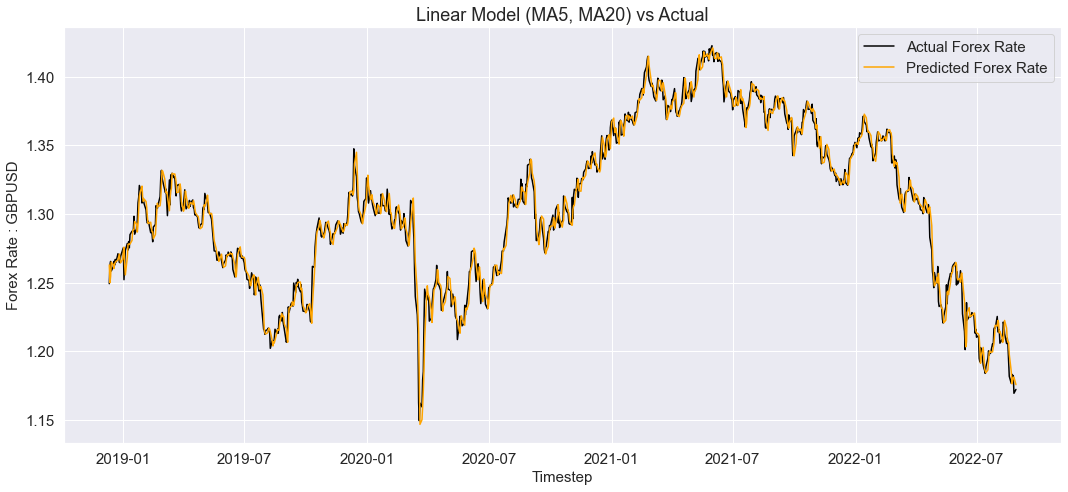

In [23]:
# plot predicted vs actual
plt.figure(figsize=(15, 7))
plt.plot(df_actual_predicted.Actual_Price, color='black', label="Actual Forex Rate")
plt.plot(df_actual_predicted.Predicted_Price, color='orange', label="Predicted Forex Rate")
plt.title("Linear Model (MA5, MA20) vs Actual", fontsize=18)
plt.legend(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD',fontsize=15)
plt.xlabel('Timestep', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()